# Interactive Puzzle Environment - Jupyter Notebook

This notebook provides an interactive environment for the PhyVPuzzle benchmark system. You can:
- Load and configure puzzle environments
- Interact with the environment using various tools
- Visualize the current state with images
- Save images and trajectories for analysis

## Setup Instructions
1. Make sure you're in the `/mnt/moonfs/wuyuhao-m2/wyh/VisualReasonBench/notebooks` directory
2. Run the cells in order
3. Use the provided functions to interact with the environment

## 1. Import Dependencies and Setup

In [1]:
# Standard libraries
import os
import sys
import json
import time
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage, clear_output
import warnings
warnings.filterwarnings('ignore')

# Add the src directory to Python path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

print(f"Project root: {project_root}")
print(f"Python path updated: {sys.path[0]}")

Project root: /mnt/moonfs/wuyuhao-m2/wyh/VisualReasonBench
Python path updated: /mnt/moonfs/wuyuhao-m2/wyh/VisualReasonBench/src


In [2]:
# Import PhyVPuzzle components
from phyvpuzzle import load_config, validate_config
from phyvpuzzle.core import ENVIRONMENT_REGISTRY, TASK_REGISTRY, AGENT_REGISTRY
from phyvpuzzle.core.base import Action

# Try to import pybullet
try:
    import pybullet as p
    print("PyBullet imported successfully")
except ImportError:
    from phyvpuzzle.environment.base_env import p
    print("Using alternative PyBullet import")

# Load environment variables (optional)
try:
    from dotenv import load_dotenv
    load_dotenv()
    print("Environment variables loaded")
except ImportError:
    print("Note: python-dotenv not available. Using system environment variables only.")

PyBullet imported successfully
Environment variables loaded


pybullet build time: Jan 29 2025 23:16:28


## 2. Define the Interactive Environment Class

In [3]:
class InteractivePuzzleEnvironment:
    """Interactive wrapper for puzzle environment with visualization capabilities."""

    def __init__(self, config_path=None):
        """Initialize the interactive environment."""
        # Load configuration
        if config_path is None:
            config_path = project_root / "eval_configs" / "puzzle_quick.yaml"

        if not config_path.exists():
            raise FileNotFoundError(f"Configuration file not found: {config_path}")

        # Load config
        self.config = load_config(str(config_path))

        # Fix the URDF path to be absolute - correct path without duplicating directories
        if hasattr(self.config.environment, 'urdf_local_path'):
            # The config has: src/phyvpuzzle/environment/phobos_models
            # We need the absolute path to phobos_models
            urdf_path = project_root / "src" / "phyvpuzzle" / "environment" / "phobos_models"
            self.config.environment.urdf_local_path = str(urdf_path)
            print(f"  URDF path set to: {urdf_path}")
            
            # Verify the 3x3 model exists
            model_path = urdf_path / "3x3-stacking-puzzle"
            if model_path.exists():
                print(f"  ✓ 3x3 model found at: {model_path}")
            else:
                print(f"  ⚠️ 3x3 model not found at: {model_path}")

        print(f"✓ Loaded configuration: {self.config.runner.experiment_name}")

        # Initialize components
        self.task = None
        self.environment = None
        self.current_observation = None
        self.step_count = 0
        self.max_steps = self.config.environment.max_steps
        self.image_history = []
        self.action_history = []

    def setup(self):
        """Setup the environment and task."""
        print("🔧 Setting up task...")
        # Create task
        task_cls = TASK_REGISTRY.get(self.config.task.type)
        if task_cls is None:
            raise RuntimeError(f"Unknown task type: {self.config.task.type}")
        self.task = task_cls(self.config.task)

        print("🔧 Setting up environment...")
        # Create environment
        env_cls = ENVIRONMENT_REGISTRY.get(self.config.environment.type)
        if env_cls is None:
            raise RuntimeError(f"Unknown environment type: {self.config.environment.type}")
        self.environment = env_cls(self.config.environment)

        print("🔧 Configuring environment with task...")
        # Configure environment with task
        self.current_observation = self.task.configure_environment(self.environment)

        print("\n" + "="*60)
        print("✅ Environment ready!")
        print(f"📋 Task: {self.task.task_id}")
        print(f"📋 Type: {self.config.task.type}")
        print(f"📋 Difficulty: {self.config.task.difficulty.value}")
        print(f"📋 Number of pieces: {self.config.task.num_pieces}")
        print(f"📋 Max steps: {self.max_steps}")
        print("="*60)

        return self.current_observation

    def get_current_image(self):
        """Get the current observation image."""
        if self.current_observation and self.current_observation.image:
            return self.current_observation.image
        return None

    def save_image(self, filename=None, step=None):
        """Save the current observation image."""
        if self.current_observation and self.current_observation.image:
            if filename is None:
                if step is None:
                    step = self.step_count
                filename = f"puzzle_step_{step:03d}.png"

            # Ensure the image is in the correct format
            img = self.current_observation.image
            if isinstance(img, np.ndarray):
                img = Image.fromarray(img)

            img.save(filename)
            print(f"💾 Image saved to {filename}")
            return filename
        else:
            print("❌ No image to save")
            return None

    def display_image(self, figsize=(8, 8)):
        """Display the current observation image using matplotlib."""
        if self.current_observation and self.current_observation.image:
            plt.figure(figsize=figsize)
            plt.imshow(self.current_observation.image)
            plt.title(f"Step {self.step_count}: {self.current_observation.description}")
            plt.axis('off')
            plt.show()
        else:
            print("❌ No image to display")

    def get_available_tools(self):
        """Get the list of available tools/actions."""
        if self.environment:
            return self.environment.get_tool_schemas()
        return []

    def get_object_mapping(self):
        """Get object ID to color/property mapping."""
        if not self.environment:
            return "Environment not initialized"

        lines = ["\n🎯 OBJECT MAPPING (object_id → RGB color):"]
        lines.append("="*50)

        non_container_count = 0

        for obj_info in self.environment.objects:
            # Skip container objects
            if obj_info.properties.get('is_container', False):
                continue

            obj_id = obj_info.object_id
            non_container_count += 1

            # Get visual shape data to retrieve color
            try:
                visual_shapes = p.getVisualShapeData(obj_id)

                if visual_shapes:
                    rgba_color = visual_shapes[0][7]  # Index 7 is rgbaColor

                    # Format color as RGB values (0-255 scale for readability)
                    r = int(rgba_color[0] * 255)
                    g = int(rgba_color[1] * 255)
                    b = int(rgba_color[2] * 255)

                    # Create a colored square for visualization
                    color_hex = f"#{r:02x}{g:02x}{b:02x}"
                    lines.append(f"  Object {obj_id}: RGB({r:3d}, {g:3d}, {b:3d}) {color_hex}")
                else:
                    lines.append(f"  Object {obj_id}: color unknown")

            except Exception as e:
                lines.append(f"  Object {obj_id}: error ({str(e)})")

        lines.append("="*50)
        lines.append(f"Total movable pieces: {non_container_count}")

        return "\n".join(lines)

    def print_objects_info(self, verbose=True):
        """打印环境中所有物体的详细信息：位置、姿态、尺寸、质量、速度等。
        
        Args:
            verbose: 是否显示详细信息（包括速度、AABB 包围盒等）
        """
        if not self.environment:
            print("❌ Environment not initialized. Call setup() first.")
            return
        
        print("\n" + "="*80)
        print("📦 OBJECTS DETAILED INFO")
        print("="*80)
        
        for idx, obj_info in enumerate(self.environment.objects):
            obj_id = obj_info.object_id
            
            # 跳过容器（可选）
            is_container = obj_info.properties.get('is_container', False)
            
            print(f"\n{'🗳️ ' if is_container else '🧩 '}Object #{idx+1} (ID: {obj_id})")
            print("-" * 80)
            
            # 基本信息
            print(f"  Name:         {obj_info.name}")
            print(f"  Type:         {obj_info.object_type}")
            if is_container:
                print(f"  Is Container: ✓")
            
            # 位置与姿态
            try:
                pos, orn = p.getBasePositionAndOrientation(obj_id)
                print(f"\n  📍 Position:  x={pos[0]:+.4f}, y={pos[1]:+.4f}, z={pos[2]:+.4f}")
                
                # 将四元数转为欧拉角（度数）
                import math
                euler = p.getEulerFromQuaternion(orn)
                roll = math.degrees(euler[0])
                pitch = math.degrees(euler[1])
                yaw = math.degrees(euler[2])
                print(f"  🔄 Orientation (Euler): roll={roll:+.1f}°, pitch={pitch:+.1f}°, yaw={yaw:+.1f}°")
                print(f"     Quaternion: x={orn[0]:+.3f}, y={orn[1]:+.3f}, z={orn[2]:+.3f}, w={orn[3]:+.3f}")
            except Exception as e:
                print(f"  ⚠️ Position/Orientation error: {e}")
            
            # 尺寸（AABB 包围盒）
            try:
                aabb_min, aabb_max = p.getAABB(obj_id)
                width = aabb_max[0] - aabb_min[0]
                depth = aabb_max[1] - aabb_min[1]
                height = aabb_max[2] - aabb_min[2]
                print(f"\n  📏 Bounding Box (AABB):")
                print(f"     Width:  {width:.4f} m")
                print(f"     Depth:  {depth:.4f} m")
                print(f"     Height: {height:.4f} m")
                print(f"     Volume: {width*depth*height:.6f} m³")
            except Exception as e:
                print(f"  ⚠️ Bounding box error: {e}")
            
            # 颜色
            try:
                visual_shapes = p.getVisualShapeData(obj_id)
                if visual_shapes:
                    rgba = visual_shapes[0][7]
                    r, g, b, a = int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255), rgba[3]
                    print(f"\n  🎨 Color:     RGB({r:3d}, {g:3d}, {b:3d}) #{r:02x}{g:02x}{b:02x}, Alpha={a:.2f}")
            except Exception:
                pass
            
            # 动力学属性
            try:
                dynamics = p.getDynamicsInfo(obj_id, -1)
                mass = dynamics[0]
                friction = dynamics[1]
                restitution = dynamics[5]
                lin_damp = dynamics[6]
                ang_damp = dynamics[7]
                
                print(f"\n  ⚖️  Mass:              {mass:.4f} kg")
                print(f"  🔧 Lateral Friction:  {friction:.4f}")
                print(f"  🏐 Restitution:       {restitution:.4f}")
                print(f"  💨 Linear Damping:    {lin_damp:.4f}")
                print(f"  🌀 Angular Damping:   {ang_damp:.4f}")
            except Exception as e:
                print(f"  ⚠️ Dynamics info error: {e}")
            
            # 速度信息（仅在 verbose 模式）
            if verbose:
                try:
                    lin_vel, ang_vel = p.getBaseVelocity(obj_id)
                    lin_speed = math.sqrt(sum(v**2 for v in lin_vel))
                    ang_speed = math.sqrt(sum(w**2 for w in ang_vel))
                    print(f"\n  🚀 Linear Velocity:  [{lin_vel[0]:+.4f}, {lin_vel[1]:+.4f}, {lin_vel[2]:+.4f}] m/s")
                    print(f"     Speed: {lin_speed:.4f} m/s")
                    print(f"  🔄 Angular Velocity: [{ang_vel[0]:+.4f}, {ang_vel[1]:+.4f}, {ang_vel[2]:+.4f}] rad/s")
                    print(f"     Speed: {ang_speed:.4f} rad/s")
                    
                    # 状态判断
                    lin_tol = getattr(self.environment.config, 'lin_vel_tol', 1e-3)
                    ang_tol = getattr(self.environment.config, 'ang_vel_tol', 1e-3)
                    is_stable = (lin_speed < lin_tol and ang_speed < ang_tol)
                    print(f"  {'✅' if is_stable else '⚠️'} Status: {'Stable' if is_stable else 'Moving'}")
                except Exception as e:
                    print(f"  ⚠️ Velocity error: {e}")
            
            # 自定义属性
            if obj_info.properties and len(obj_info.properties) > 1:  # 大于 1 因为可能只有 is_container
                print(f"\n  📝 Custom Properties:")
                for key, val in obj_info.properties.items():
                    if key != 'is_container':
                        print(f"     {key}: {val}")
        
        print("\n" + "="*80)
        total_objs = len(self.environment.objects)
        containers = sum(1 for o in self.environment.objects if o.properties.get('is_container', False))
        print(f"Total: {total_objs} objects ({total_objs - containers} movable, {containers} containers)")
        print("="*80 + "\n")

    def execute_action(self, action_type, parameters):
        """Execute an action in the environment."""
        if not self.environment:
            print("❌ Environment not initialized. Call setup() first.")
            return None

        if self.step_count >= self.max_steps:
            print(f"⚠️ Maximum steps ({self.max_steps}) reached!")
            return None

        # Create action
        action = Action(action_type=action_type, parameters=parameters)

        print(f"\n🎮 Executing: {action_type}({parameters})")

        # Execute action
        self.current_observation = self.environment.step(action)
        self.step_count += 1

        # Store in history
        self.action_history.append({
            "step": self.step_count,
            "action": action_type,
            "parameters": parameters,
            "result": self.current_observation.description
        })
        
        if self.current_observation.image:
            self.image_history.append(self.current_observation.image)

        print(f"📊 Step {self.step_count}/{self.max_steps}")
        print(f"✅ Result: {self.current_observation.description}")

        if 'tool_result' in self.current_observation.state.metadata:
            result = self.current_observation.state.metadata['tool_result']
            if isinstance(result, dict):
                print(f"📝 Status: {result.get('status', 'unknown')}")
                if result.get('message'):
                    print(f"📝 Message: {result['message']}")

        return self.current_observation

    def reset(self):
        """Reset the environment."""
        if self.environment:
            self.environment.close()

        self.step_count = 0
        self.image_history = []
        self.action_history = []
        self.setup()
        print("🔄 Environment reset complete")

    def close(self):
        """Close the environment."""
        if self.environment:
            self.environment.close()
            print("👋 Environment closed")

    def get_task_info(self):
        """Get information about the current task."""
        if not self.task:
            return "Task not initialized"

        info = {
            "Task ID": self.task.task_id,
            "Task Type": self.config.task.type,
            "Task Name": self.config.task.name,
            "Difficulty": self.config.task.difficulty.value,
            "Number of pieces": self.config.task.num_pieces,
            "Puzzle size": self.config.task.puzzle_size,
            "Piece size": self.config.task.piece_size,
            "Current step": f"{self.step_count}/{self.max_steps}",
            "Optimal steps": getattr(self.task, 'optimal_steps', 'Unknown')
        }
        return info

    def print_task_info(self):
        """Print task information in a formatted way."""
        info = self.get_task_info()
        print("\n📋 Task Information:")
        print("="*40)
        for key, value in info.items():
            print(f"  {key}: {value}")
        print("="*40)

    def print_available_tools(self):
        """Print available tools in a formatted way."""
        tools = self.get_available_tools()
        print("\n🛠️ Available Tools:")
        print("="*60)
        for i, tool in enumerate(tools, 1):
            name = tool['function']['name']
            desc = tool['function']['description']
            print(f"{i}. {name}:")
            print(f"   {desc[:100]}..." if len(desc) > 100 else f"   {desc}")
            print()
        print("="*60)

    def save_trajectory(self, filename="trajectory.json"):
        """Save the current trajectory to a JSON file."""
        trajectory = {
            "task_info": self.get_task_info(),
            "steps": self.step_count,
            "max_steps": self.max_steps,
            "actions": self.action_history,
            "image_count": len(self.image_history)
        }

        with open(filename, 'w') as f:
            json.dump(trajectory, f, indent=2, default=str)

        print(f"💾 Trajectory saved to {filename}")

    def create_animation(self, filename="puzzle_animation.gif", duration=500):
        """Create an animated GIF from the image history."""
        if not self.image_history:
            print("❌ No images in history")
            return

        # Convert numpy arrays to PIL Images
        images = []
        for img in self.image_history:
            if isinstance(img, np.ndarray):
                images.append(Image.fromarray(img))
            else:
                images.append(img)

        # Save as animated GIF
        images[0].save(
            filename,
            save_all=True,
            append_images=images[1:],
            duration=duration,
            loop=0
        )
        print(f"🎬 Animation saved to {filename}")

print("✅ InteractivePuzzleEnvironment class defined successfully!")

✅ InteractivePuzzleEnvironment class defined successfully!


## 3. Initialize the Environment

In [4]:
# Create the interactive environment
env = InteractivePuzzleEnvironment()
print("✅ Environment instance created!")

  URDF path set to: /mnt/moonfs/wuyuhao-m2/wyh/VisualReasonBench/src/phyvpuzzle/environment/phobos_models
  ✓ 3x3 model found at: /mnt/moonfs/wuyuhao-m2/wyh/VisualReasonBench/src/phyvpuzzle/environment/phobos_models/3x3-stacking-puzzle
✓ Loaded configuration: puzzle_assembly_quick_test
✅ Environment instance created!


In [5]:
# Setup the environment and task
initial_obs = env.setup()

# Display initial observation
print(f"\n📝 Initial Observation: {initial_obs.description}")

🔧 Setting up task...
🔧 Setting up environment...
🔧 Configuring environment with task...
PyBullet initialized. Client ID: 0


→ Container original size: ~0.413m
→ Estimated unit cube size: ~0.156m
→ Required container size (3x3x3): ~0.563m per side
→ Calculated container scale: 1.50x
→ Max piece dimensions: W=0.385m, D=0.385m, H=0.385m
Loading 8 puzzle parts from /mnt/moonfs/wuyuhao-m2/wyh/VisualReasonBench/src/phyvpuzzle/environment/phobos_models/3x3-stacking-puzzle ...
✅ Loaded 8 puzzle parts successfully.
→ Container scaled by 1.50x to accommodate all pieces
→ Pieces spawned on ground in 3x3 grid
→ Grid cell size: (0.463m, 0.463m), ground z=0.050m
→ Container position: x_offset=0.139m
Settle used: 2000

✅ Environment ready!
📋 Task: 3x3_stacking_1759988613
📋 Type: 3x3_stacking
📋 Difficulty: medium
📋 Number of pieces: 9
📋 Max steps: 10

📝 Initial Observation: 


## 4. Explore the Environment

In [6]:
# Show object mapping (which objects exist and their colors)
print(env.get_object_mapping())


🎯 OBJECT MAPPING (object_id → RGB color):
  Object 8: RGB(222, 197,  12) #dec50c
  Object 7: RGB(201,  88,   0) #c95800
  Object 6: RGB(169,  27,   0) #a91b00
  Object 5: RGB(  0,  87,  43) #00572b
  Object 3: RGB(  0,  42, 113) #002a71
  Object 2: RGB( 23, 115, 206) #1773ce
  Object 1: RGB(153,  48,  97) #993061
Total movable pieces: 7


In [7]:
# Show available tools/actions
env.print_available_tools()


🛠️ Available Tools:
1. move_object:
   Move an object to a specific 3D position in the workspace. The object will be teleported to the targ...

2. rotate_object:
   Rotate an object around a specified axis by a given angle. The rotation is applied relative to the o...

3. observe:
   Change camera viewpoint to observe the scene from a different angle. The camera rotates around the c...

4. finish:
   Signal that you have completed the task successfully. ONLY call this when you believe all task objec...

5. place_into_container:
   Place a puzzle piece into the container at a specified offset position relative to the container's c...



In [8]:
# Show task information
env.print_task_info()


📋 Task Information:
  Task ID: 3x3_stacking_1759988613
  Task Type: 3x3_stacking
  Task Name: 3x3_stacking_puzzle
  Difficulty: medium
  Number of pieces: 9
  Puzzle size: [3, 3]
  Piece size: 0.08
  Current step: 0/10
  Optimal steps: 10



📦 OBJECTS DETAILED INFO

🧩 Object #1 (ID: 8)
--------------------------------------------------------------------------------
  Name:         piece_1
  Type:         puzzle_piece

  📍 Position:  x=+0.7385, y=-0.7598, z=+0.0635
  🔄 Orientation (Euler): roll=-0.0°, pitch=-0.0°, yaw=-0.0°
     Quaternion: x=-0.000, y=-0.000, z=-0.000, w=+1.000

  📏 Bounding Box (AABB):
     Width:  0.3855 m
     Depth:  0.2605 m
     Height: 0.1355 m
     Volume: 0.013608 m³

  🎨 Color:     RGB(222, 197,  12) #dec50c, Alpha=1.00

  ⚖️  Mass:              0.0500 kg
  🔧 Lateral Friction:  1.0000
  🏐 Restitution:       0.0000
  💨 Linear Damping:    0.0020
  🌀 Angular Damping:   0.0020

  🚀 Linear Velocity:  [-0.0000, +0.0000, -0.0000] m/s
     Speed: 0.0000 m/s
  🔄 Angular Velocity: [-0.0000, -0.0000, -0.0000] rad/s
     Speed: 0.0000 rad/s
  ✅ Status: Stable

  📝 Custom Properties:
     index: 0

🧩 Object #2 (ID: 7)
--------------------------------------------------------------------------------
  Name:   

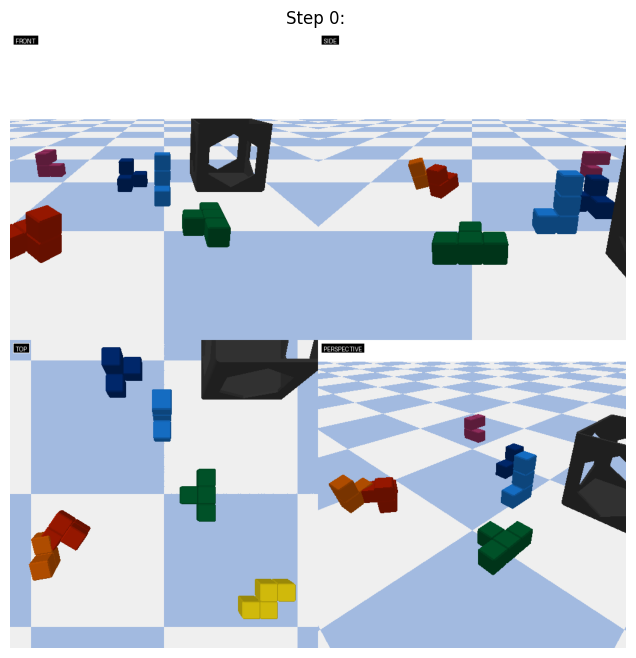

In [9]:
# Display the current image
env.print_objects_info()
env.display_image()

In [10]:
# Save the initial state image
env.save_image("initial_state.png")

💾 Image saved to initial_state.png


'initial_state.png'

## 5. Interactive Actions

Now you can interact with the environment using the available tools. Here are some examples:

In [11]:
# # Example 1: Observe from different angles
# obs = env.execute_action("observe", {"angle": 90})
# env.display_image()


# 11. 逐帧保存：从执行动作开始到模拟稳定的每一帧
from pathlib import Path
from typing import List, Dict, Any, Optional

try:
    import pybullet as p  # 与环境相同的连接会被共享
except ImportError:
    from phyvpuzzle.environment.base_env import p

from phyvpuzzle.core.base import Action as CoreAction


def _to_pil_image(img):
    """将 numpy/PIL 图像统一转为 PIL.Image.Image。"""
    if img is None:
        return None
    if isinstance(img, np.ndarray):
        return Image.fromarray(img)
    return img


def capture_frames_during_action(
    env,
    action_type: str,
    parameters: Dict[str, Any],
    num_substeps: int = 200,
    save_dir: str = "frames",
    save_every: int = 1,
    prefix: Optional[str] = None,
    stop_when_stable: bool = True,
) -> List[str]:
    """
    执行动作但不使用环境的自动“稳定等待”，而是手动逐步 stepSimulation，并在每个子步抓取并保存图像。

    - env: 交互环境实例（InteractivePuzzleEnvironment）
    - action_type/parameters: 与 env.execute_action 相同
    - num_substeps: 最多模拟的子步帧数
    - save_dir: 图像保存目录
    - save_every: 每隔多少子步保存一帧（=1 则每步都保存）
    - prefix: 文件名前缀；默认用 action_type
    - stop_when_stable: 基于当前 config 阈值，检测物体速度全都低于阈值则提前停止
    返回：保存的文件路径列表
    """
    assert env is not None and env.environment is not None, "Environment 未初始化，请先运行 env.setup()"

    save_root = Path(save_dir)
    save_root.mkdir(parents=True, exist_ok=True)

    if prefix is None:
        prefix = action_type

    saved_files: List[str] = []

    # 1) 动作前一帧（可选）
    pre_img = env.get_current_image()
    pre_pil = _to_pil_image(pre_img)
    if pre_pil is not None:
        pre_path = save_root / f"{prefix}_pre.png"
        pre_pil.save(pre_path)
        saved_files.append(str(pre_path))
        # 也纳入历史，便于后续做 GIF
        env.image_history.append(pre_pil)

    # 2) 仅执行工具逻辑（不触发环境内部的稳定等待）
    tool_res = env.environment.execute_tool_call(CoreAction(action_type=action_type, parameters=parameters))
    print(f"Tool Call Result: {tool_res}")

    # 3) 逐帧 step 并渲染保存
    object_ids = [obj.object_id for obj in env.environment.objects]
    lin_tol = env.environment.config.lin_vel_tol
    ang_tol = env.environment.config.ang_vel_tol

    def _all_objects_stable() -> bool:
        for bid in object_ids:
            lin, ang = p.getBaseVelocity(bid)
            if any(abs(v) >= lin_tol for v in lin) or any(abs(w) >= ang_tol for w in ang):
                return False
        return True

    for sub_idx in range(num_substeps):
        p.stepSimulation()

        # 渲染当前帧
        frame = env.environment.render()

        # 多视角或单视角
        if isinstance(frame, dict):
            # 为每个视角单独保存
            for cam_name, cam_img in frame.items():
                if save_every == 1 or (sub_idx % save_every == 0):
                    pil_img = _to_pil_image(cam_img)
                    frame_path = save_root / f"{prefix}_substep_{sub_idx:04d}_{cam_name}.png"
                    pil_img.save(frame_path)
                    saved_files.append(str(frame_path))
                    # 仅把主视角（若存在“perspective”）加入历史，便于 GIF
                    if cam_name == "perspective":
                        env.image_history.append(pil_img)
        else:
            if save_every == 1 or (sub_idx % save_every == 0):
                pil_img = _to_pil_image(frame)
                frame_path = save_root / f"{prefix}_substep_{sub_idx:04d}.png"
                pil_img.save(frame_path)
                saved_files.append(str(frame_path))
                env.image_history.append(pil_img)

        if stop_when_stable and _all_objects_stable():
            print(f"稳定检测通过，提前在子步 {sub_idx} 停止。")
            break

    # 4) 返回保存的所有文件路径
    print(f"共保存 {len(saved_files)} 张图像，目录：{save_root}")
    return saved_files


# 使用示例：逐帧记录一次移动动作（按需修改 object_id/position）
# files = capture_frames_during_action(
#     env,
#     action_type="move_object",
#     parameters={"object_id": 1, "position": [0.0, 0.0, 0.1]},
#     num_substeps=200,
#     save_dir="frames_move_object",
#     save_every=1,
#     prefix="move_obj_1_to_0_0_0p1",
#     stop_when_stable=True,
# )
# print(files[-5:])  # 查看最后几帧文件名


In [12]:
# Example 2: Move an object (frame-by-frame saving)
files = capture_frames_during_action(
    env,
    action_type="move_object",
    parameters={"object_id": 1, "position": [0.0, 0.0, 0.1]},
    num_substeps=2000,
    save_dir="frames_move_object",
    save_every=200,
    prefix="move_obj_1_to_0_0_0p1",
    stop_when_stable=True,
)
print(f"Saved {len(files)} images to 'frames_move_object'. Last: {files[-1] if files else 'N/A'}")

Tool Call Result: {'status': 'success', 'message': 'Moved object_id 1 to position [0.0, 0.0, 0.1]'}


KeyboardInterrupt: 

In [ ]:
# Example 3: Rotate an object
obs = env.execute_action("rotate_object", {
    "object_id": 1,  # Change this to the actual object ID
    "angle": 90,
    "axis": [0, 0, 1]  # Rotate around z-axis
})
env.display_image()

In [ ]:
# Example 4: Place piece into container
obs = env.execute_action("place_into_container", {
    "object_id": 1,  # Change this to the actual object ID
    "offset_x": 0.0,
    "offset_y": 0.0,
    "offset_z": 0.0
})
env.display_image()

## 6. Custom Action Sequences

You can create your own sequences of actions to solve the puzzle:

In [ ]:
# Define a sequence of actions
action_sequence = [
    ("observe", {"angle": 0}),
    ("move_object", {"object_id": 1, "position": [0.0, 0.0, 0.2]}),
    ("observe", {"angle": 90}),
    # Add more actions as needed
]

# Execute the sequence
for action_type, params in action_sequence:
    obs = env.execute_action(action_type, params)
    env.display_image()
    time.sleep(0.5)  # Small delay between actions

## 7. Save Results and Analysis

In [ ]:
# Save the current trajectory
env.save_trajectory("my_puzzle_trajectory.json")

In [ ]:
# Create an animation from all the steps
if len(env.image_history) > 1:
    env.create_animation("puzzle_solving.gif", duration=1000)
else:
    print("Not enough images for animation. Execute more actions first.")

In [ ]:
# Display all images in a grid
if env.image_history:
    n_images = len(env.image_history)
    cols = min(4, n_images)
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = axes.flatten() if n_images > 1 else [axes]
    
    for i, img in enumerate(env.image_history):
        axes[i].imshow(img)
        axes[i].set_title(f"Step {i}")
        axes[i].axis('off')
    
    # Hide extra subplots
    for i in range(n_images, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No images in history yet.")

## 8. Reset or Close Environment

In [ ]:
# Reset the environment to start over
# env.reset()

In [ ]:
# Close the environment when done
# env.close()

## 9. Advanced: Custom Interaction Loop

You can create a more sophisticated interaction loop with your own logic:

In [ ]:
def solve_puzzle_step_by_step(env):
    """
    Example function to solve the puzzle step by step.
    You can modify this with your own solving strategy.
    """
    print("🎯 Starting puzzle solving sequence...\n")
    
    # Get object IDs (assuming 9 pieces for 3x3 puzzle)
    object_ids = list(range(1, 10))
    
    # Define positions for a 3x3 grid
    positions = [
        [-0.1, -0.1, 0.05],  # Bottom left
        [0.0, -0.1, 0.05],   # Bottom center
        [0.1, -0.1, 0.05],   # Bottom right
        [-0.1, 0.0, 0.05],   # Middle left
        [0.0, 0.0, 0.05],    # Center
        [0.1, 0.0, 0.05],    # Middle right
        [-0.1, 0.1, 0.05],   # Top left
        [0.0, 0.1, 0.05],    # Top center
        [0.1, 0.1, 0.05],    # Top right
    ]
    
    # Try to place each piece
    for i, (obj_id, pos) in enumerate(zip(object_ids, positions)):
        if env.step_count >= env.max_steps:
            print("⚠️ Reached maximum steps!")
            break
            
        print(f"\n📍 Placing piece {obj_id} at position {i+1}/9")
        
        # Use place_into_container for better placement
        obs = env.execute_action("place_into_container", {
            "object_id": obj_id,
            "offset_x": pos[0],
            "offset_y": pos[1],
            "offset_z": pos[2]
        })
        
        # Display current state
        env.display_image()
        
        # Small delay for visualization
        time.sleep(0.3)
    
    print("\n✅ Solving sequence completed!")
    print(f"Used {env.step_count}/{env.max_steps} steps")
    
    # Optionally call finish if all pieces are placed
    if env.step_count < env.max_steps:
        env.execute_action("finish", {})

# Uncomment to run the solving sequence
# solve_puzzle_step_by_step(env)

## 10. Tips and Notes

### Available Actions:
- **move_object**: Move an object to a specific 3D position
- **rotate_object**: Rotate an object around a specified axis
- **observe**: Change camera viewpoint (0°=front, 90°=right, 180°=back, 270°=left)
- **place_into_container**: Place a piece into the container with offset
- **finish**: Signal task completion

### Coordinate System:
- X-axis: Left (-) to Right (+)
- Y-axis: Back (-) to Front (+)
- Z-axis: Down (0) to Up (+)

### Best Practices:
1. Use `observe` to view the puzzle from different angles
2. Use `place_into_container` for precise piece placement
3. Save images after important steps for analysis
4. Keep track of object IDs and their colors
5. Remember the maximum step limit

### Troubleshooting:
- If actions fail, check object IDs are correct
- Ensure positions are within workspace bounds
- Reset the environment if needed
- Close and reinitialize if the environment becomes unresponsive

In [ ]:
# 11. 逐帧保存：从执行动作开始到模拟稳定的每一帧
from pathlib import Path
from typing import List, Dict, Any, Optional

try:
    import pybullet as p  # 与环境相同的连接会被共享
except ImportError:
    from phyvpuzzle.environment.base_env import p

from phyvpuzzle.core.base import Action as CoreAction


def _to_pil_image(img):
    """将 numpy/PIL 图像统一转为 PIL.Image.Image。"""
    if img is None:
        return None
    if isinstance(img, np.ndarray):
        return Image.fromarray(img)
    return img


def capture_frames_during_action(
    env,
    action_type: str,
    parameters: Dict[str, Any],
    num_substeps: int = 200,
    save_dir: str = "frames",
    save_every: int = 1,
    prefix: Optional[str] = None,
    stop_when_stable: bool = True,
) -> List[str]:
    """
    执行动作但不使用环境的自动“稳定等待”，而是手动逐步 stepSimulation，并在每个子步抓取并保存图像。

    - env: 交互环境实例（InteractivePuzzleEnvironment）
    - action_type/parameters: 与 env.execute_action 相同
    - num_substeps: 最多模拟的子步帧数
    - save_dir: 图像保存目录
    - save_every: 每隔多少子步保存一帧（=1 则每步都保存）
    - prefix: 文件名前缀；默认用 action_type
    - stop_when_stable: 基于当前 config 阈值，检测物体速度全都低于阈值则提前停止
    返回：保存的文件路径列表
    """
    assert env is not None and env.environment is not None, "Environment 未初始化，请先运行 env.setup()"

    save_root = Path(save_dir)
    save_root.mkdir(parents=True, exist_ok=True)

    if prefix is None:
        prefix = action_type

    saved_files: List[str] = []

    # 1) 动作前一帧（可选）
    pre_img = env.get_current_image()
    pre_pil = _to_pil_image(pre_img)
    if pre_pil is not None:
        pre_path = save_root / f"{prefix}_pre.png"
        pre_pil.save(pre_path)
        saved_files.append(str(pre_path))
        # 也纳入历史，便于后续做 GIF
        env.image_history.append(pre_pil)

    # 2) 仅执行工具逻辑（不触发环境内部的稳定等待）
    tool_res = env.environment.execute_tool_call(CoreAction(action_type=action_type, parameters=parameters))
    print(f"Tool Call Result: {tool_res}")

    # 3) 逐帧 step 并渲染保存
    object_ids = [obj.object_id for obj in env.environment.objects]
    lin_tol = env.environment.config.lin_vel_tol
    ang_tol = env.environment.config.ang_vel_tol

    def _all_objects_stable() -> bool:
        for bid in object_ids:
            lin, ang = p.getBaseVelocity(bid)
            if any(abs(v) >= lin_tol for v in lin) or any(abs(w) >= ang_tol for w in ang):
                return False
        return True

    for sub_idx in range(num_substeps):
        p.stepSimulation()

        # 渲染当前帧
        frame = env.environment.render()

        # 多视角或单视角
        if isinstance(frame, dict):
            # 为每个视角单独保存
            for cam_name, cam_img in frame.items():
                if save_every == 1 or (sub_idx % save_every == 0):
                    pil_img = _to_pil_image(cam_img)
                    frame_path = save_root / f"{prefix}_substep_{sub_idx:04d}_{cam_name}.png"
                    pil_img.save(frame_path)
                    saved_files.append(str(frame_path))
                    # 仅把主视角（若存在“perspective”）加入历史，便于 GIF
                    if cam_name == "perspective":
                        env.image_history.append(pil_img)
        else:
            if save_every == 1 or (sub_idx % save_every == 0):
                pil_img = _to_pil_image(frame)
                frame_path = save_root / f"{prefix}_substep_{sub_idx:04d}.png"
                pil_img.save(frame_path)
                saved_files.append(str(frame_path))
                env.image_history.append(pil_img)

        if stop_when_stable and _all_objects_stable():
            print(f"稳定检测通过，提前在子步 {sub_idx} 停止。")
            break

    # 4) 返回保存的所有文件路径
    print(f"共保存 {len(saved_files)} 张图像，目录：{save_root}")
    return saved_files


# 使用示例：逐帧记录一次移动动作（按需修改 object_id/position）
# files = capture_frames_during_action(
#     env,
#     action_type="move_object",
#     parameters={"object_id": 1, "position": [0.0, 0.0, 0.1]},
#     num_substeps=200,
#     save_dir="frames_move_object",
#     save_every=1,
#     prefix="move_obj_1_to_0_0_0p1",
#     stop_when_stable=True,
# )
# print(files[-5:])  # 查看最后几帧文件名
